This notebook uses data gathered using the static analysis tool of [codequality-uo](https://github.com/HPCL/code-analysis/tree/main/src/dockerStuff) and identifies the most *crucial* functions in petsc, compares two methods of identifying these functions, and seeks to track the evolution of these functions over the years in terms of various code quality metric scores.

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [3]:
import networkit as nk 
import networkx as nx 

In [67]:
versions = ['310', '311', '312', '313', '314', '3150', '3160'] 
PETSC = {} 
for v in versions: 
  PETSC[v] = {} 
  v_filenameCG = "logs/petscCG" + v + ".csv" 
  v_filenameQM = "logs/petscQM" + v + ".csv" 
  v_filenameGR = "logs/petscGR" + v + ".TabOne"
  v_filenameNM = "logs/petscNM" + v + ".txt"
  PETSC[v]['CG'] = pd.read_csv(v_filenameCG) 
  PETSC[v]['QM'] = pd.read_csv(v_filenameQM)
  PETSC[v]['GR'] = nx.read_edgelist(v_filenameGR, create_using=nx.DiGraph())
  PETSC[v]['GR'] = nk.nxadapter.nx2nk(PETSC[v]['GR'])
  with open(v_filenameNM, 'r') as v_filenameNM_r: 
    PETSC[v]['NM'] = v_filenameNM_r.readlines()

In [68]:
sizes = []
for v in versions: 
  sizes.append(PETSC[v]['CG'].size)
  print("verions ", v, "size: ", PETSC[v]['CG'].size)

verions  310 size:  101240
verions  311 size:  105010
verions  312 size:  119130
verions  313 size:  122910
verions  314 size:  126790
verions  3150 size:  128650
verions  3160 size:  142520


In [69]:
for v in versions: 
  PETSC[v]['CG'] = PETSC[v]['CG'].loc[PETSC[v]['CG'].Betweenness > 0]

In [70]:
from networkit.centrality import PageRank 
pageranked = [] 
for v in versions: 
  G      = PETSC[v]['GR']
  G_page = PageRank(G)
  p = G_page.run() 
  p = p.ranking()
  pageranked.append(p)

In [71]:
ranking_named = [] 
for j in range(len(pageranked)):  
  p = pageranked[j]
  to_append          = list(map(lambda x : (PETSC[versions[j]]['NM'][x[0]].strip(), x[1]), p))
  to_append_df       = pd.DataFrame(data=to_append, columns=['Name', 'PageRank'])
  # to_append_df.index = to_append_df.Name
  # to_append_df.drop(columns=['Name'])
  to_append_df       = to_append_df[to_append_df.index.isin(PETSC[versions[j]]['CG'].index)]
  to_append_df       = to_append_df.sort_values(by=['PageRank'], ascending=False) 
  to_append_df.index = to_append_df.Name 
  ranking_named.append(to_append_df)
ranking_named[0].head()

,Name,PageRank
Name,,
MatView_SchurComplement,MatView_SchurComplement,0.051051
MatMult_SchurComplement,MatMult_SchurComplement,0.026290
VecScale,VecScale,0.025339
MatMult,MatMult,0.025011
MatMultTransposeAdd,MatMultTransposeAdd,0.024761


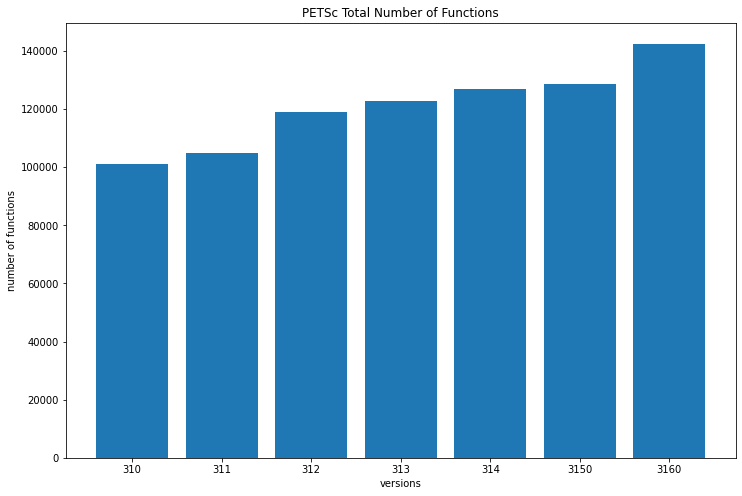

In [72]:
fig, ax = plt.subplots(figsize=(12,8), nrows=1, ncols=1)
ax.bar(x=versions, height=sizes)
ax.set_title("PETSc Total Number of Functions")
ax.set_xlabel("versions")
ax.set_ylabel("number of functions")
plt.savefig("PetscTotalFunctions.png", bbox_inches='tight')

In [73]:
nk.overview(PETSC['3160']['GR'])

Network Properties:
nodes, edges			14253, 105545
directed?			True
weighted?			False
isolated nodes			1568
self-loops			89
density				0.000519
min/max/avg degree		0, 162, 7.405108
degree assortativity		0.206918
number of connected components	14112
size of largest component	18 (0.13 %)


In [74]:
PETSC['3160']['CG'].head()

,Unnamed: 0,Name,FanIn,FanOut,IsIsolated,AvgShortestPath,Closeness,Betweenness,Eccentricity_R,Eccentricity_N
1,1,MatCreateVecs,116,12,False,304.147365,0.003288,34215.401238,8,11550
2,2,PetscError,10794,8,False,544.814955,0.001835,640716.605687,5,1182
6,6,PetscViewerASCIIPrintf,334,15,False,550.465171,0.001817,8910.511693,6,1182
7,7,PetscViewerASCIIPushTab,100,5,False,678.532037,0.001474,48.201796,6,1182
8,8,MatView,38,29,False,283.204176,0.003531,4077.003844,8,10766


In [75]:
PETSC['3160']['QM'].head()

,Name,ArgCount,InstrCount,UniqVals,UniqOps,TotalOps,CC
0,ADMMInternalHessianUpdate,4 4,105 105,0 0,7 7,14 14,13 13
1,ADMML1EpsilonNorm,3 3,128 128,0 0,11 11,22 22,13 13
2,ADMMUpdateConstraintResidualVector,6 6,127 127,0 0,8 8,20 20,15 15
3,AOApplicationToPetsc,3 3 3 3,116 0 0 0,0 0 0 0,6 0 0 0,18 0 0 0,16 1 1 1
4,AOApplicationToPetscIS,2,160,0,11,30,22


In [76]:
for v in versions: 
  for c in PETSC[v]['QM'].columns: 
    if c != 'Name': 
      PETSC[v]['QM'][c] = PETSC[v]['QM'][c].apply(lambda x : max([int(s) if (s != 'VARGS') 
                          and not (s in PETSC[v]['QM'].columns) else 0 for s in x.strip().split()]))

In [77]:
PETSC['3160']['QM'].head()

,Name,ArgCount,InstrCount,UniqVals,UniqOps,TotalOps,CC
0,ADMMInternalHessianUpdate,4,105,0,7,14,13
1,ADMML1EpsilonNorm,3,128,0,11,22,13
2,ADMMUpdateConstraintResidualVector,6,127,0,8,20,15
3,AOApplicationToPetsc,3,116,0,6,18,16
4,AOApplicationToPetscIS,2,160,0,11,30,22


In [78]:
missing_double_cols = ['AvgShortestPath', 'Betweenness', 'Closeness'] 
for v in versions: 
    frame = PETSC[v]['CG']
    for c in missing_double_cols: 
      frame[c] = (np.where(frame[c] == (' ' + c), 0.0, frame[c])).astype(float)

In [79]:
for v in versions: 
  PETSC[v]['QM'].index = PETSC[v]['QM'].Name 
  PETSC[v]['CG'].index = PETSC[v]['CG'].Name

In [80]:
# append fanout column to QM data sets 
for v in versions: 
  PETSC[v]['QM']['FanOut'] = PETSC[v]['CG']['FanOut']

In [81]:
for v in versions: 
  PETSC[v]['QM'] = PETSC[v]['QM'].drop(columns=['Name', 'InstrCount', 'UniqVals'])

In [82]:
PETSC['3160']['QM'].head()

,ArgCount,UniqOps,TotalOps,CC,FanOut
Name,,,,,
ADMMInternalHessianUpdate,4,7,14,13,5.0
ADMML1EpsilonNorm,3,11,22,13,8.0
ADMMUpdateConstraintResidualVector,6,8,20,15,7.0
AOApplicationToPetsc,3,6,18,16,5.0
AOApplicationToPetscIS,2,11,30,22,NaN


In [83]:
tick_labels = ['', ''] + [str(versions[i]) + '-' + str(versions[i + 1]) for i in range(len(versions) - 1)]

/tmp/ipykernel_19/1647185822.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(tick_labels)
/tmp/ipykernel_19/1647185822.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(tick_labels)


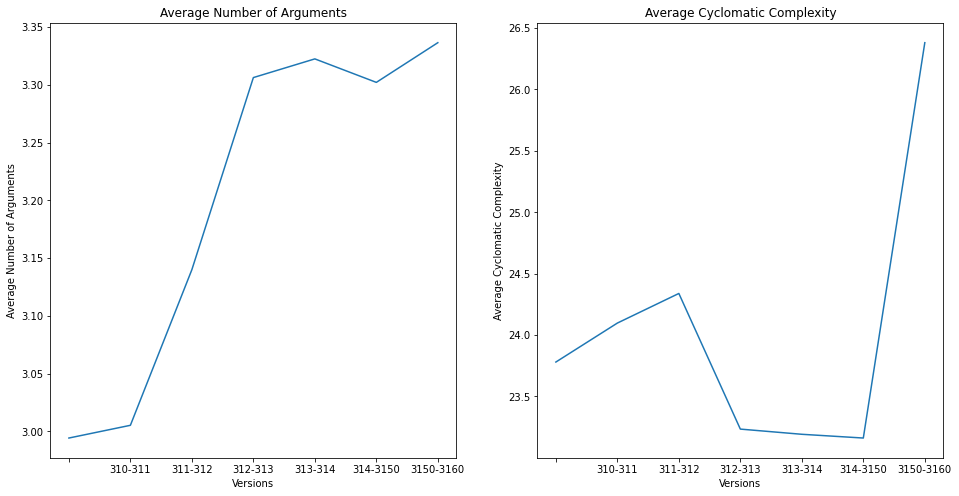

In [84]:
intrst_metrics = ['ArgCount', 'CC'] 
avg_ms_dict = {} 
for m in intrst_metrics: 
  avg_ms_dict[m] = [] 

for v in versions: 
  avg_ms_dict['ArgCount'].append(PETSC[v]['QM']['ArgCount'].mean()) 
  avg_ms_dict['CC'].append(PETSC[v]['QM']['CC'].mean())
  # avg_ms_dict['UniqVals'].append(PETSC[v]['QM']['UniqVals'].mean())

fig, ax = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
ax[0].plot(avg_ms_dict['ArgCount'])
ax[0].set_title('Average Number of Arguments')
ax[0].set_xlabel('Versions')
ax[1].set_xlabel('Versions')
ax[0].set_ylabel('Average Number of Arguments')
ax[1].set_ylabel('Average Cyclomatic Complexity')
ax[1].plot(avg_ms_dict['CC'])
ax[1].set_title('Average Cyclomatic Complexity')
# ax[1].plot(20)
# ax[1][0].plot(avg_ms_dict['UniqVals'])
ax[0].set_xticklabels(tick_labels)
ax[1].set_xticklabels(tick_labels)
plt.savefig("ArgsAndCCTrendsPostBetweenFilter.pdf", bbox_inches='tight')

/tmp/ipykernel_19/1295632708.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(tick_labels)
/tmp/ipykernel_19/1295632708.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(tick_labels)


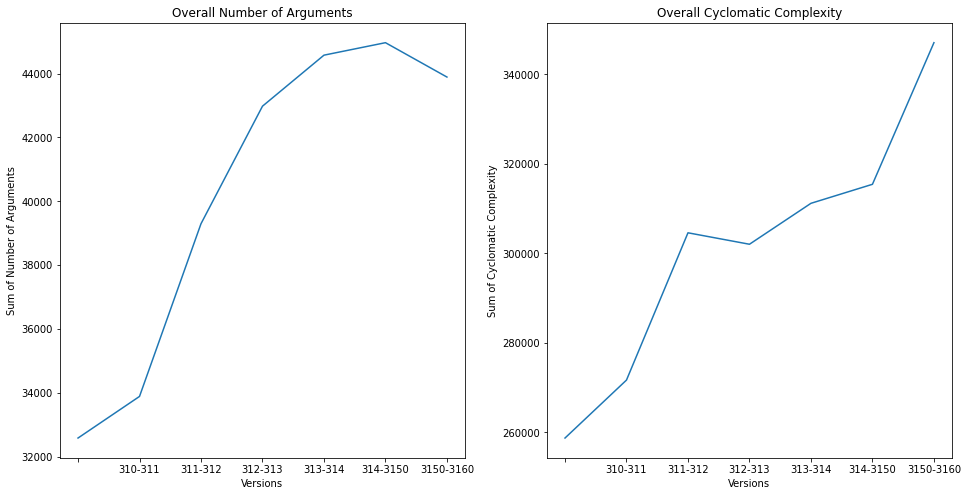

In [85]:
intrst_metrics = ['ArgCount', 'CC'] 
avg_ms_dict = {} 
for m in intrst_metrics: 
  avg_ms_dict[m] = [] 

for v in versions: 
  avg_ms_dict['ArgCount'].append(PETSC[v]['QM']['ArgCount'].sum()) 
  avg_ms_dict['CC'].append(PETSC[v]['QM']['CC'].sum())
  # avg_ms_dict['UniqVals'].append(PETSC[v]['QM']['UniqVals'].mean())

fig, ax = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
ax[0].plot(avg_ms_dict['ArgCount'])
ax[0].set_title('Overall Number of Arguments')
ax[1].plot(avg_ms_dict['CC'])
ax[1].set_title('Overall Cyclomatic Complexity')
# ax[1].plot(20)
# ax[1][0].plot(avg_ms_dict['UniqVals'])
ax[0].set_xticklabels(tick_labels)
ax[0].set_xlabel('Versions')
ax[0].set_ylabel('Sum of Number of Arguments')
ax[1].set_xticklabels(tick_labels)
ax[1].set_xlabel('Versions') 
ax[1].set_ylabel('Sum of Cyclomatic Complexity')
plt.savefig("ArgsAndCCTrendsPostBetweenFilter", bbox_inches='tight')

In [86]:
radii = [] 
diams = [] 
for v in versions: 
  radii.append(PETSC[v]['CG']['Eccentricity_R'].min())
  diams.append(PETSC[v]['CG']['Eccentricity_R'].max())

In [87]:
tops = [] 
for i in range(len(versions)): 
  v = versions[i]
  centrals = PETSC[v]['CG'].loc[PETSC[v]['CG']['Eccentricity_R'] == (radii[i])] 
  tops.append(centrals)

In [88]:
tops[0].head()

,Unnamed: 0,Name,FanIn,FanOut,IsIsolated,AvgShortestPath,Closeness,Betweenness,Eccentricity_R,Eccentricity_N
Name,,,,,,,,,,
PetscCheckPointer,37,PetscCheckPointer,3108,3,False,3374.333333,0.000296,27722.462121,1,4900
PetscMPIParallelComm,62,PetscMPIParallelComm,556,1,False,10123.000000,0.000099,1380.436400,1,66
PetscStrcmp,149,PetscStrcmp,110,1,False,10123.000000,0.000099,9114.177208,1,5802
PetscStrlen,284,PetscStrlen,74,1,False,10123.000000,0.000099,9106.284524,1,7931
PetscIsInfOrNanReal,403,PetscIsInfOrNanReal,54,2,False,5061.500000,0.000198,1807.683333,1,411


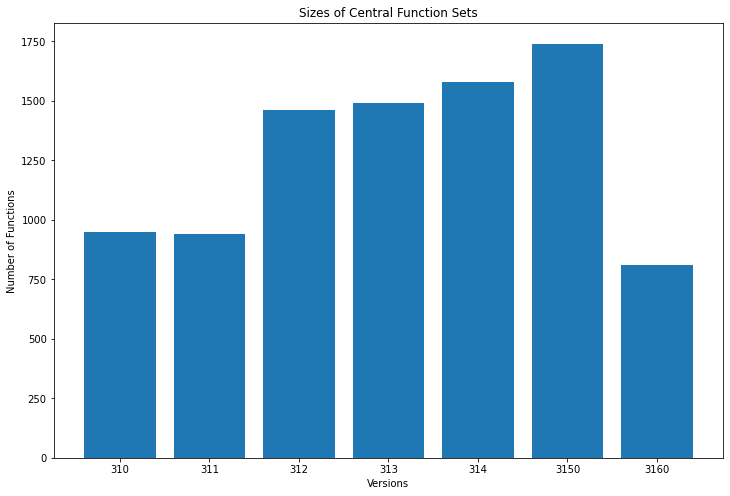

In [89]:
tops_bar_plot = [i.size for i in tops] 
fig, ax = plt.subplots(figsize=(12,8), nrows=1, ncols=1)
ax.bar(x=versions, height=tops_bar_plot)
ax.set_title('Sizes of Central Function Sets')
ax.set_xlabel('Versions')
ax.set_ylabel('Number of Functions')
plt.savefig('CoreSizes.pdf', bbox_inches='tight')

In [90]:
pageranked_top = [ranking_named[i].Name.head(top_size) for i, top_size in enumerate(tops_bar_plot)]

In [91]:
pageranked_top_dfs = [] 
for i in range(len(versions)): 
  pg_top_names = pageranked_top[i] 
  cg_df_index  = PETSC[versions[i]]['CG'].index 
  pg_df        = PETSC[versions[i]]['CG'][cg_df_index.isin(pg_top_names.index)] 
  pg_df        = pg_df.loc[pg_df.Betweenness > 0]
  pageranked_top_dfs.append(pg_df)
pageranked_top_dfs[0].head() 

,Unnamed: 0,Name,FanIn,FanOut,IsIsolated,AvgShortestPath,Closeness,Betweenness,Eccentricity_R,Eccentricity_N
Name,,,,,,,,,,
MatCreateVecs,1,MatCreateVecs,92,9,False,243.401911,0.004108,20956.284717,7,7933
PetscViewerASCIIPushTab,5,PetscViewerASCIIPushTab,82,3,False,474.515625,0.002107,58.931393,7,7967
MatView,6,MatView,38,20,False,233.729291,0.004278,2922.762413,8,7725
PetscViewerASCIIPopTab,7,PetscViewerASCIIPopTab,81,3,False,474.515625,0.002107,57.431393,7,7967
KSPView,8,KSPView,21,23,False,123.332098,0.008108,4352.901464,10,7666


In [92]:
diffs = [] 
for i in range(len(versions)): 
  top_central    = tops[i] 
  top_pgrank     = pageranked_top[i] 
  dfs_diffs      = top_pgrank[top_pgrank.index.isin(top_central.index)].size / top_pgrank.size 
  diffs.append(dfs_diffs) 
diffs 

[0.008421052631578947,
 0.013829787234042552,
 0.01780821917808219,
 0.010738255033557046,
 0.013291139240506329,
 0.013793103448275862,
 0.011111111111111112]

# Comparing rankings found via PageRank vs Eccentricity

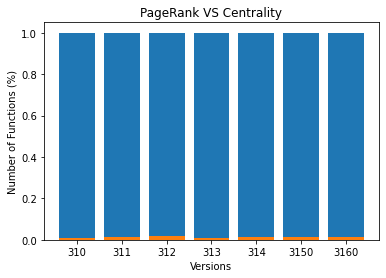

In [106]:
plt.bar(x=versions, height=[1] * len(versions))
plt.bar(x=versions, height=diffs)
plt.title('PageRank VS Centrality')
plt.xlabel('Versions')
plt.ylabel('Number of Functions (%)')
plt.savefig('CentralVSPage.pdf', bbox_inches='tight')

## How much do 'central' or 'core' functions cover?

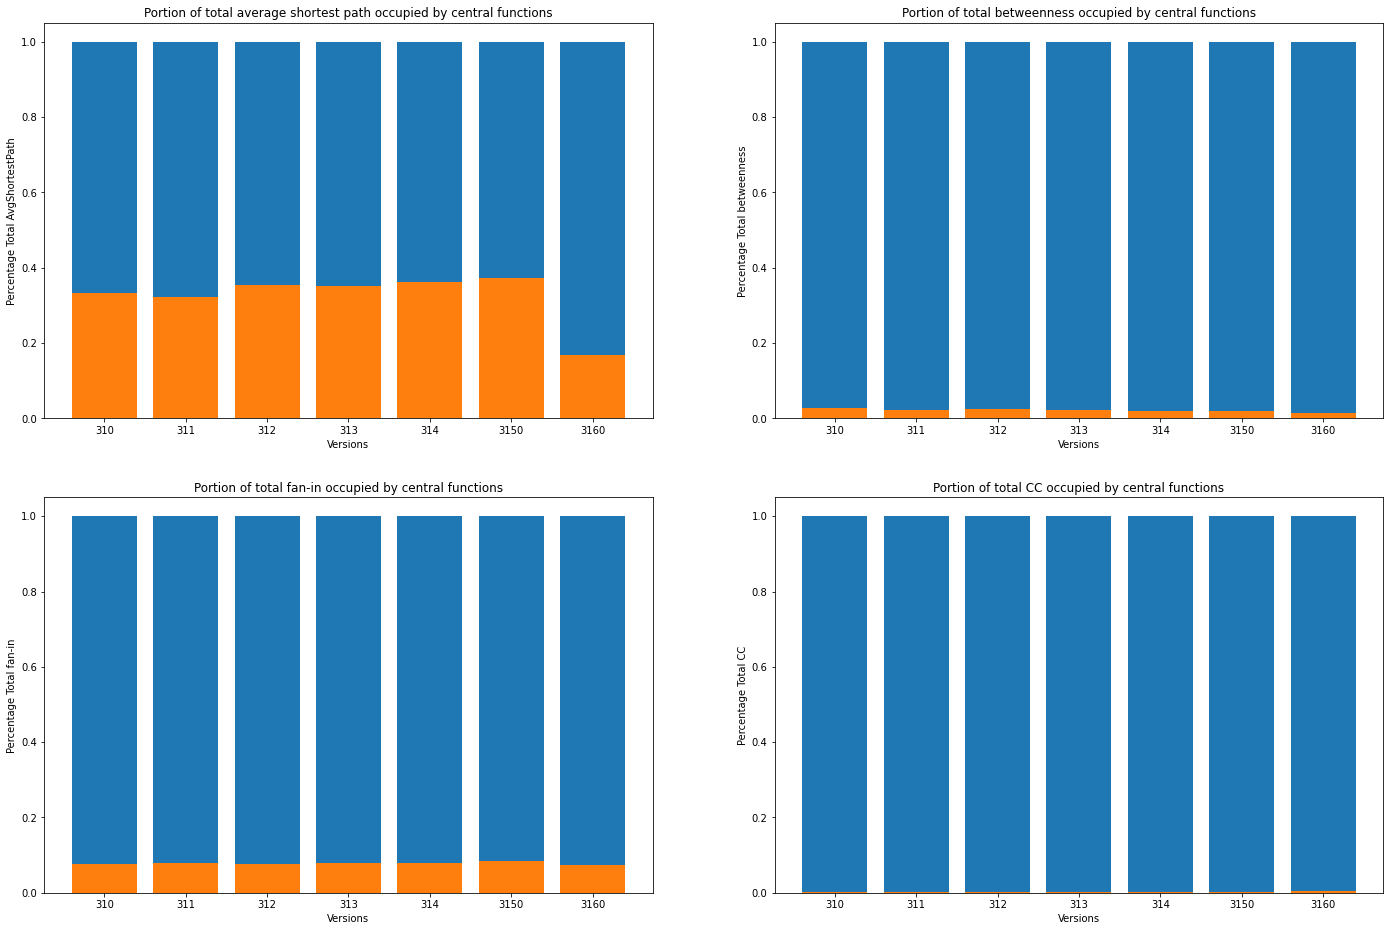

In [94]:
percentages = {'CC': [], 'AvgShortestPath' : [], 'Betweenness' : [], 'FanIn' : []}
for i, v in enumerate(versions): 
  for metric in percentages: 
    if metric != 'CC': 
      percentages[metric].append(tops[i][metric].sum() / PETSC[v]['CG'][metric].sum())
    else: 
      top_index = tops[i].index 
      qm_index  = PETSC[v]['QM'].index 
      top_qvals = PETSC[v]['QM'][qm_index.isin(top_index)]
      percentages[metric].append(top_qvals[metric].sum() / PETSC[v]['QM'][metric].sum())  
percentages 


fig, ax = plt.subplots(figsize=(24,16), nrows=2, ncols=2)
ax[0][0].bar(x=versions, height=[1] * len(versions))
ax[0][0].bar(x=versions, height=percentages['AvgShortestPath'])
ax[0][0].set_title('Portion of total average shortest path occupied by central functions')
ax[0][0].set_xlabel('Versions')
ax[0][0].set_ylabel('Percentage Total AvgShortestPath')

ax[0][1].bar(x=versions, height=[1] * len(versions))
ax[0][1].bar(x=versions, height=percentages['Betweenness'])
ax[0][1].set_title('Portion of total betweenness occupied by central functions')
ax[0][1].set_xlabel('Versions')
ax[0][1].set_ylabel('Percentage Total betweenness')

ax[1][0].bar(x=versions, height=[1] * len(versions))
ax[1][0].bar(x=versions, height=percentages['FanIn'])
ax[1][0].set_title('Portion of total fan-in occupied by central functions')
ax[1][0].set_xlabel('Versions')
ax[1][0].set_ylabel('Percentage Total fan-in')

ax[1][1].bar(x=versions, height=[1] * len(versions))
ax[1][1].bar(x=versions, height=percentages['CC'])
ax[1][1].set_title('Portion of total CC occupied by central functions')
ax[1][1].set_xlabel('Versions')
ax[1][1].set_ylabel('Percentage Total CC')

plt.savefig('petscPowerLaw.pdf', bbox_inches='tight')

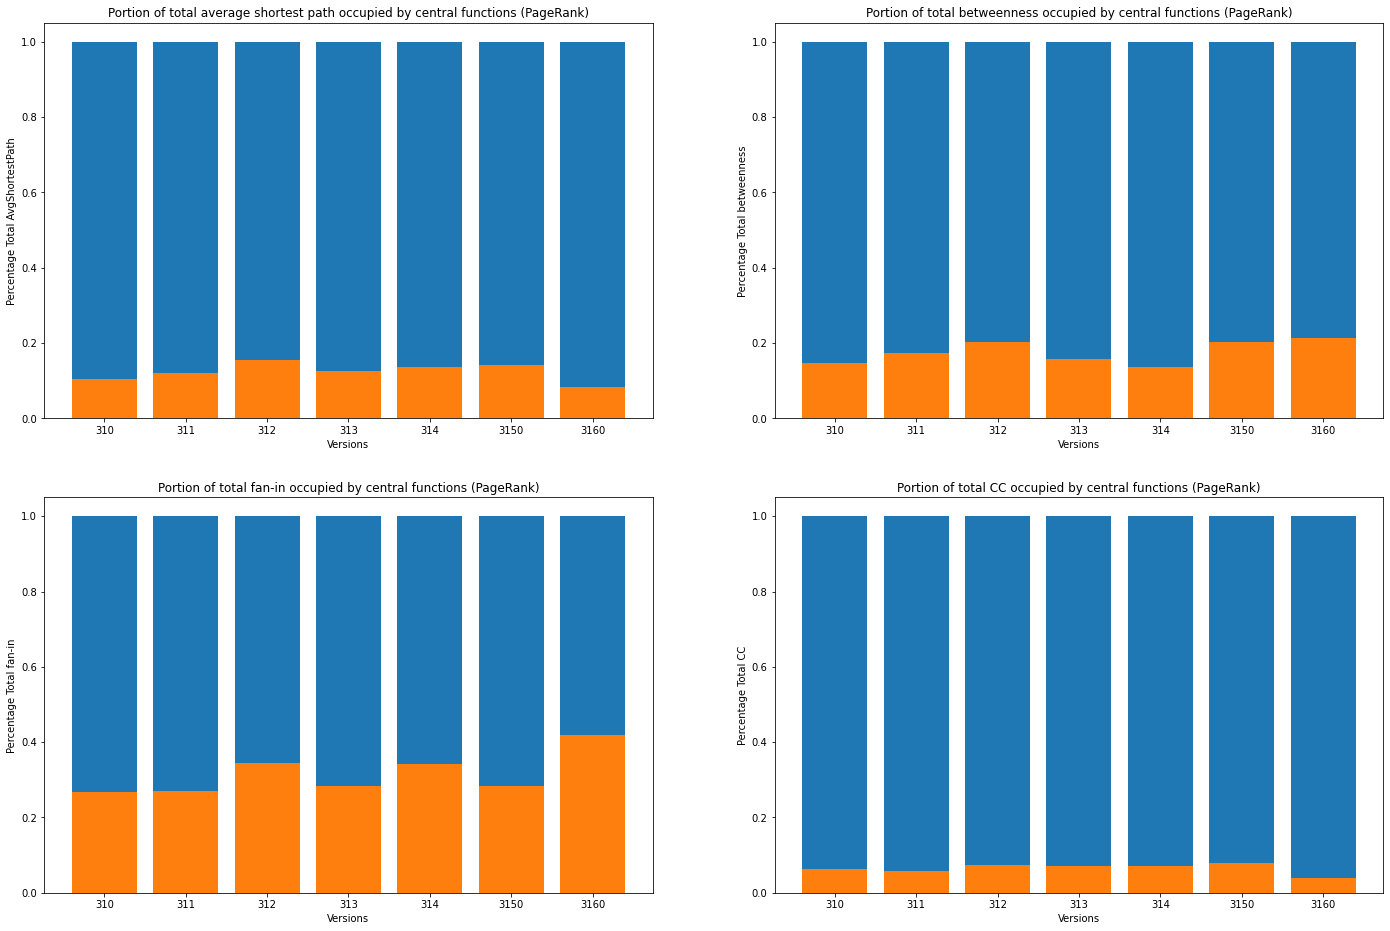

In [107]:
percentages = {'CC': [], 'AvgShortestPath' : [], 'Betweenness' : [], 'FanIn' : []}
for i, v in enumerate(versions): 
  for metric in percentages: 
    if metric != 'CC': 
      percentages[metric].append(pageranked_top_dfs[i][metric].sum() / PETSC[v]['CG'][metric].sum())
    else: 
      top_index = pageranked_top_dfs[i].index 
      qm_index  = PETSC[v]['QM'].index 
      top_qvals = PETSC[v]['QM'][qm_index.isin(top_index)]
      percentages[metric].append(top_qvals[metric].sum() / PETSC[v]['QM'][metric].sum())  
percentages 


fig, ax = plt.subplots(figsize=(24,16), nrows=2, ncols=2)
ax[0][0].bar(x=versions, height=[1] * len(versions))
ax[0][0].bar(x=versions, height=percentages['AvgShortestPath'])
ax[0][0].set_title('Portion of total average shortest path occupied by central functions (PageRank)')
ax[0][0].set_xlabel('Versions')
ax[0][0].set_ylabel('Percentage Total AvgShortestPath')

ax[0][1].bar(x=versions, height=[1] * len(versions))
ax[0][1].bar(x=versions, height=percentages['Betweenness'])
ax[0][1].set_title('Portion of total betweenness occupied by central functions (PageRank)')
ax[0][1].set_xlabel('Versions')
ax[0][1].set_ylabel('Percentage Total betweenness')

ax[1][0].bar(x=versions, height=[1] * len(versions))
ax[1][0].bar(x=versions, height=percentages['FanIn'])
ax[1][0].set_title('Portion of total fan-in occupied by central functions (PageRank)')
ax[1][0].set_xlabel('Versions')
ax[1][0].set_ylabel('Percentage Total fan-in')

ax[1][1].bar(x=versions, height=[1] * len(versions))
ax[1][1].bar(x=versions, height=percentages['CC'])
ax[1][1].set_title('Portion of total CC occupied by central functions (PageRank)')
ax[1][1].set_xlabel('Versions')
ax[1][1].set_ylabel('Percentage Total CC')

plt.savefig('petscPowerLawPageRank.pdf', bbox_inches='tight')

**Thus, overall, pagerank's ranking produces top functions which are more powerful (occupy larger portions of FanIn, Betweenness, Average Shortest Paths, Cyclomatic Complexity)**

------

# Tracking The Evolution of Core Functions

In [96]:
CORE_NUM = 10
version0 = versions[0] 
versionL = versions[-1]

In [97]:
top_grp0 = tops[0].head(CORE_NUM) 
top_grpL = tops[-1].head(CORE_NUM)

In [98]:
top_grp_pgrank_0 = pageranked_top_dfs[0].head(CORE_NUM) 
top_grp_pgrank_L = pageranked_top_dfs[-1].head(CORE_NUM)

In [99]:
markers = ['o--', 'v--', '^--', '<--', '>--', '8--', 's--', 'p--', '*--', '1--', '2--', 'D--', 'd--', 'P--', 'X--']

/tmp/ipykernel_19/654108023.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([e for j, e in enumerate([''] + versions)])
/tmp/ipykernel_19/654108023.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([e for j, e in enumerate([''] + versions)])


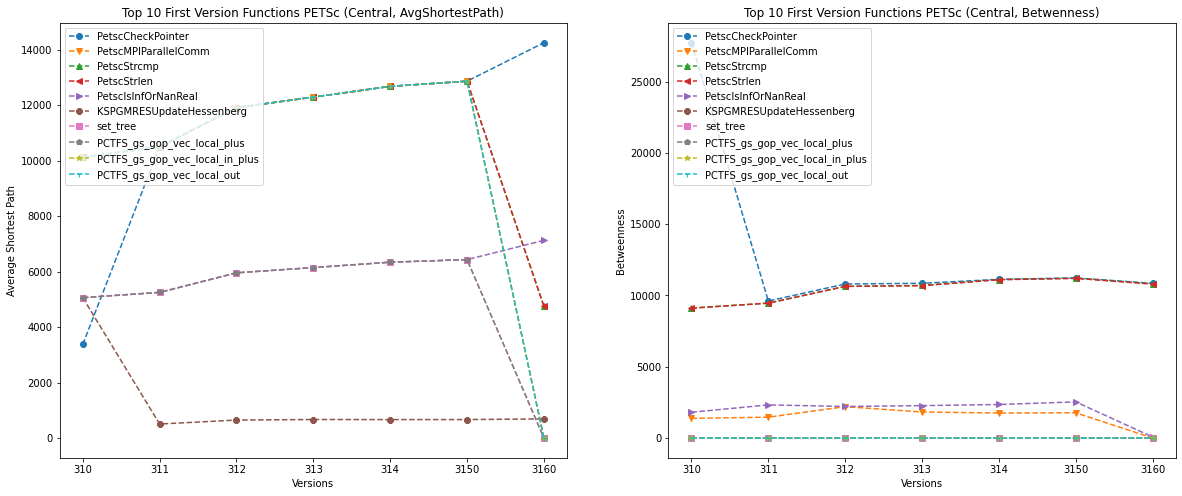

In [100]:
plots   = [] 
lacking = [] 
my_max = 0 
for v in versions: 
  to_plot   = [] 
  not_found = [] 
  for func in top_grp0.index: 
    try: 
      to_plot.append(PETSC[v]['CG'].AvgShortestPath[func]) 
    except KeyError: 
      to_plot.append(0) 
      not_found.append(func) 
  if max(to_plot) > my_max:
    my_max = max(to_plot)
  lacking.append(not_found) 
  plots.append(np.array(to_plot))  
np_plots = np.array(plots) 
i = 0 
fig, ax = plt.subplots(figsize=(20,8), nrows=1, ncols=2) 
# ax[0].set_ylim(my_max)
ax[0].set_title('Top 10 First Version Functions PETSc (Central, AvgShortestPath)')
ax[0].set_xticklabels([e for j, e in enumerate([''] + versions)]) 
ax[0].set_xlabel('Versions')
ax[0].set_ylabel('Average Shortest Path')

for arr in np_plots.T: 
  ax[0].plot(arr, markers[i]) 
  i += 1 
ax[0].legend(top_grp0.index, loc='upper left')
# plt.savefig("Top10FirstVersionCentral.pdf", bbox_inches='tight')

# with Betweenness 
plots   = [] 
lacking = [] 
for v in versions: 
  to_plot   = [] 
  not_found = [] 
  for func in top_grp0.index: 
    try: 
      to_plot.append(PETSC[v]['CG'].Betweenness[func]) 
    except KeyError: 
      to_plot.append(0) 
      not_found.append(func) 
  if max(to_plot) > my_max: 
    my_max = max(to_plot)
  lacking.append(not_found) 
  plots.append(np.array(to_plot))  
np_plots = np.array(plots) 
i = 0 
# fig, ax = plt.subplots(figsize=(12,16), nrows=1, ncols=2) 
# ax[0].set_ylim(my_max)
# ax[1].set_ylim(my_max)
ax[1].set_title('Top 10 First Version Functions PETSc (Central, Betwenness)')
ax[1].set_xticklabels([e for j, e in enumerate([''] + versions)]) 
ax[1].set_xlabel('Versions')
ax[1].set_ylabel('Betweenness')

for arr in np_plots.T: 
  ax[1].plot(arr, markers[i]) 
  i += 1 
ax[1].legend(top_grp0.index, loc='upper left')
plt.savefig("Top10FirstVersionCentral.pdf", bbox_inches='tight')

/tmp/ipykernel_19/2807838385.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([e for j, e in enumerate([''] + versions)])
/tmp/ipykernel_19/2807838385.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([e for j, e in enumerate([''] + versions)])


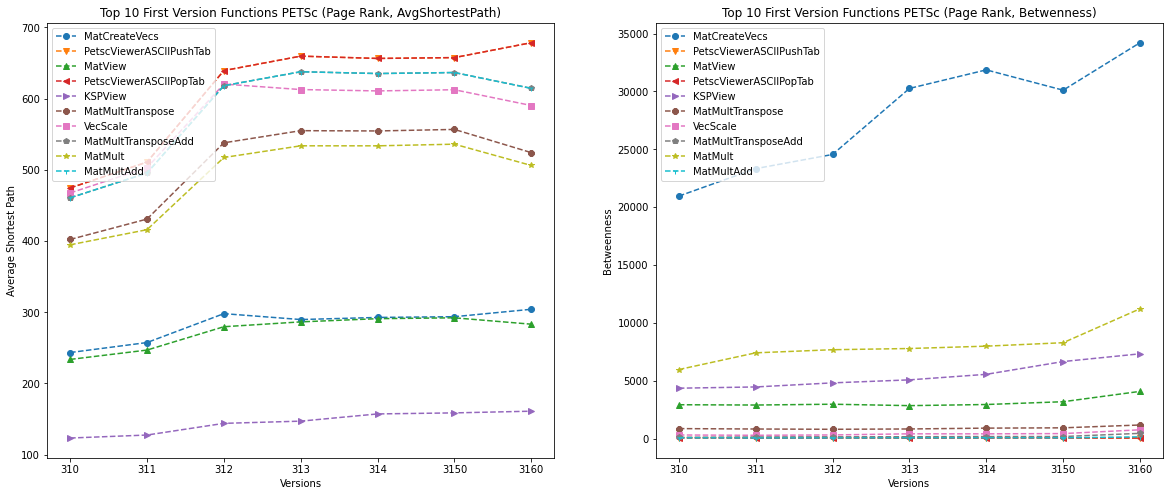

In [101]:
plots   = [] 
lacking = [] 
my_max = 0 
for v in versions: 
  to_plot   = [] 
  not_found = [] 
  for func in top_grp_pgrank_0.index: 
    try: 
      to_plot.append(PETSC[v]['CG'].AvgShortestPath[func]) 
    except KeyError: 
      to_plot.append(0) 
      not_found.append(func) 
  # if max(to_plot) > my_max:
    my_max = max(to_plot)
  lacking.append(not_found) 
  plots.append(np.array(to_plot))  
np_plots = np.array(plots) 
i = 0 
fig, ax = plt.subplots(figsize=(20,8), nrows=1, ncols=2) 
# ax[0].set_ylim(my_max)
ax[0].set_title('Top 10 First Version Functions PETSc (Page Rank, AvgShortestPath)')
ax[0].set_xticklabels([e for j, e in enumerate([''] + versions)]) 
ax[0].set_xlabel('Versions')
ax[0].set_ylabel('Average Shortest Path')

for arr in np_plots.T: 
  ax[0].plot(arr, markers[i]) 
  i += 1 
ax[0].legend(top_grp_pgrank_0.index, loc='upper left')
# plt.savefig("Top10FirstVersionCentral.pdf", bbox_inches='tight')

# with Betweenness 
plots   = [] 
lacking = [] 
for v in versions: 
  to_plot   = [] 
  not_found = [] 
  for func in top_grp_pgrank_0.index: 
    try: 
      to_plot.append(PETSC[v]['CG'].Betweenness[func]) 
    except KeyError: 
      to_plot.append(0) 
      not_found.append(func) 
  # if max(to_plot) > my_max: 
    my_max = max(to_plot)
  lacking.append(not_found) 
  plots.append(np.array(to_plot))  
np_plots = np.array(plots) 
i = 0 
# fig, ax = plt.subplots(figsize=(12,16), nrows=1, ncols=2) 
# ax[0].set_ylim(my_max)
# ax[1].set_ylim(my_max)
ax[1].set_title('Top 10 First Version Functions PETSc (Page Rank, Betwenness)')
ax[1].set_xticklabels([e for j, e in enumerate([''] + versions)]) 
ax[1].set_xlabel('Versions')
ax[1].set_ylabel('Betweenness')

for arr in np_plots.T: 
  ax[1].plot(arr, markers[i]) 
  i += 1 
ax[1].legend(top_grp_pgrank_0.index, loc='upper left')
plt.savefig("Top10FirstVersionCentral.pdf", bbox_inches='tight')

/tmp/ipykernel_19/3525328693.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([e for j, e in enumerate([''] + versions)])
/tmp/ipykernel_19/3525328693.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([e for j, e in enumerate([''] + versions)])


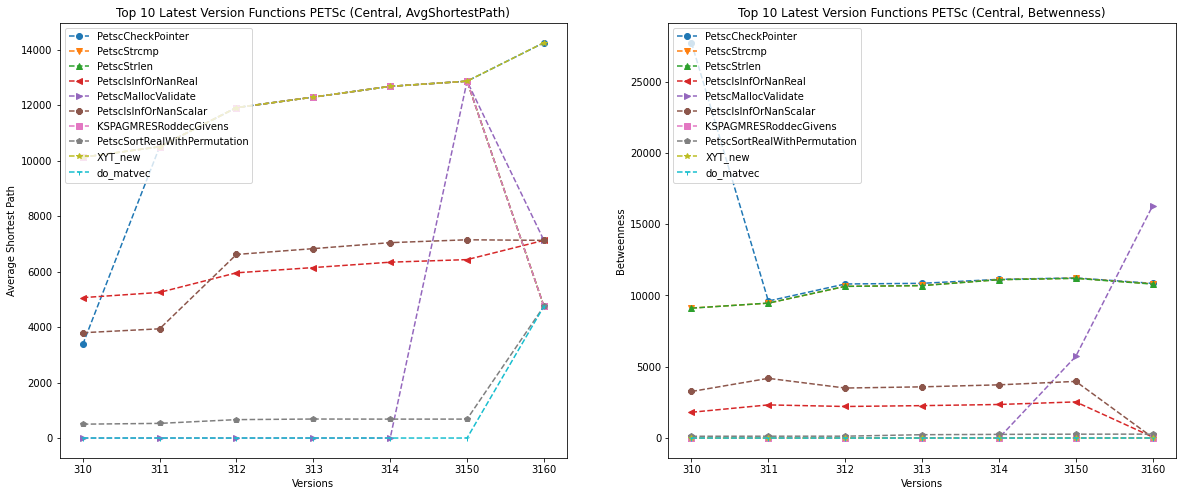

In [102]:
plots   = [] 
lacking = [] 
my_max = 0 
for v in versions: 
  to_plot   = [] 
  not_found = [] 
  for func in top_grpL.index: 
    try: 
      to_plot.append(PETSC[v]['CG'].AvgShortestPath[func]) 
    except KeyError: 
      to_plot.append(0) 
      not_found.append(func) 
  if max(to_plot) > my_max:
    my_max = max(to_plot)
  lacking.append(not_found) 
  plots.append(np.array(to_plot))  
np_plots = np.array(plots) 
i = 0 
fig, ax = plt.subplots(figsize=(20,8), nrows=1, ncols=2) 
# ax[0].set_ylim(my_max)
ax[0].set_title('Top 10 Latest Version Functions PETSc (Central, AvgShortestPath)')
ax[0].set_xticklabels([e for j, e in enumerate([''] + versions)]) 
ax[0].set_xlabel('Versions')
ax[0].set_ylabel('Average Shortest Path')

for arr in np_plots.T: 
  ax[0].plot(arr, markers[i]) 
  i += 1 
ax[0].legend(top_grpL.index, loc='upper left')
# plt.savefig("Top10FirstVersionCentral.pdf", bbox_inches='tight')

# with Betweenness 
plots   = [] 
lacking = [] 
for v in versions: 
  to_plot   = [] 
  not_found = [] 
  for func in top_grpL.index: 
    try: 
      to_plot.append(PETSC[v]['CG'].Betweenness[func]) 
    except KeyError: 
      to_plot.append(0) 
      not_found.append(func) 
  if max(to_plot) > my_max: 
    my_max = max(to_plot)
  lacking.append(not_found) 
  plots.append(np.array(to_plot))  
np_plots = np.array(plots) 
i = 0 
# fig, ax = plt.subplots(figsize=(12,16), nrows=1, ncols=2) 
# ax[0].set_ylim(my_max)
# ax[1].set_ylim(my_max)
ax[1].set_title('Top 10 Latest Version Functions PETSc (Central, Betwenness)')
ax[1].set_xticklabels([e for j, e in enumerate([''] + versions)]) 
ax[1].set_xlabel('Versions')
ax[1].set_ylabel('Betweenness')

for arr in np_plots.T: 
  ax[1].plot(arr, markers[i]) 
  i += 1 
ax[1].legend(top_grpL.index, loc='upper left')
plt.savefig("Top10LatestVersionCentral.pdf", bbox_inches='tight')

/tmp/ipykernel_19/285698445.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([e for j, e in enumerate([''] + versions)])
/tmp/ipykernel_19/285698445.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([e for j, e in enumerate([''] + versions)])


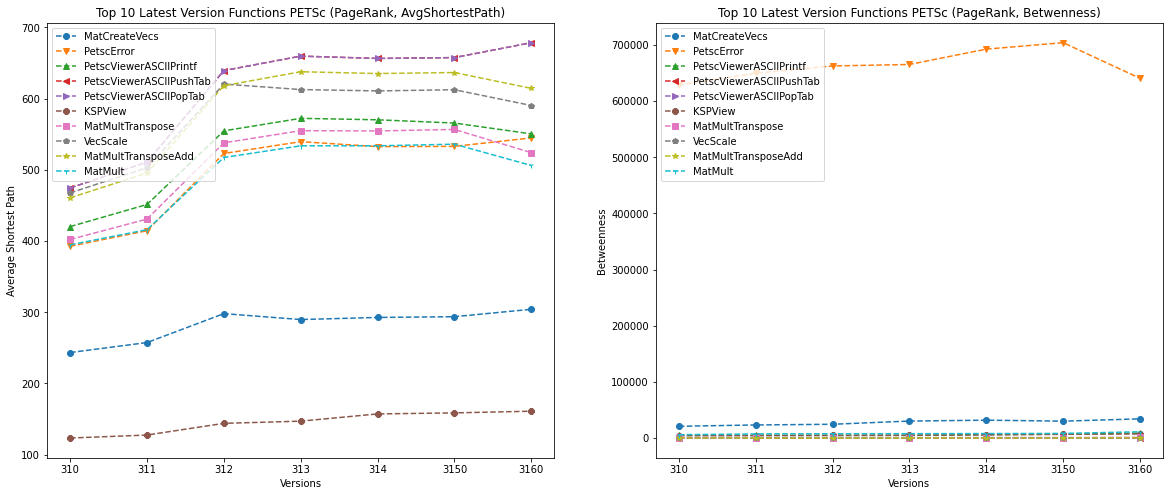

In [103]:
plots   = [] 
lacking = [] 
my_max = 0 
for v in versions: 
  to_plot   = [] 
  not_found = [] 
  for func in top_grp_pgrank_L.index: 
    try: 
      to_plot.append(PETSC[v]['CG'].AvgShortestPath[func]) 
    except KeyError: 
      to_plot.append(0) 
      not_found.append(func) 
  if max(to_plot) > my_max:
    my_max = max(to_plot)
  lacking.append(not_found) 
  plots.append(np.array(to_plot))  
np_plots = np.array(plots) 
i = 0 
fig, ax = plt.subplots(figsize=(20,8), nrows=1, ncols=2) 
# ax[0].set_ylim(my_max)
ax[0].set_title('Top 10 Latest Version Functions PETSc (PageRank, AvgShortestPath)')
ax[0].set_xticklabels([e for j, e in enumerate([''] + versions)]) 
ax[0].set_xlabel('Versions')
ax[0].set_ylabel('Average Shortest Path')

for arr in np_plots.T: 
  ax[0].plot(arr, markers[i]) 
  i += 1 
ax[0].legend(top_grp_pgrank_L.index, loc='upper left')
# plt.savefig("Top10FirstVersionCentral.pdf", bbox_inches='tight')

# with Betweenness 
plots   = [] 
lacking = [] 
for v in versions: 
  to_plot   = [] 
  not_found = [] 
  for func in top_grp_pgrank_L.index: 
    try: 
      to_plot.append(PETSC[v]['CG'].Betweenness[func]) 
    except KeyError: 
      to_plot.append(0) 
      not_found.append(func) 
  if max(to_plot) > my_max: 
    my_max = max(to_plot)
  lacking.append(not_found) 
  plots.append(np.array(to_plot))  
np_plots = np.array(plots) 
i = 0 
# fig, ax = plt.subplots(figsize=(12,16), nrows=1, ncols=2) 
# ax[0].set_ylim(my_max)
# ax[1].set_ylim(my_max)
ax[1].set_title('Top 10 Latest Version Functions PETSc (PageRank, Betwenness)')
ax[1].set_xticklabels([e for j, e in enumerate([''] + versions)]) 
ax[1].set_xlabel('Versions')
ax[1].set_ylabel('Betweenness')

for arr in np_plots.T: 
  ax[1].plot(arr, markers[i]) 
  i += 1 
ax[1].legend(top_grp_pgrank_L.index, loc='upper left')
plt.savefig("Top10LatestVersionPageRank.pdf", bbox_inches='tight')

/tmp/ipykernel_19/2587369640.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([e for j, e in enumerate([''] + versions)])
/tmp/ipykernel_19/2587369640.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([e for j, e in enumerate([''] + versions)])


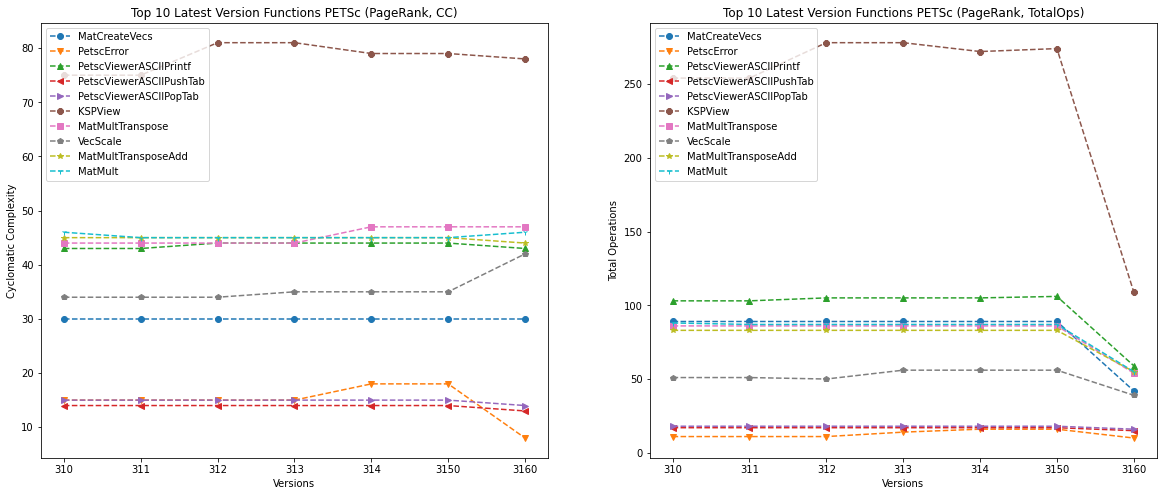

In [104]:
plots   = [] 
lacking = [] 
my_max = 0 
for v in versions: 
  to_plot   = [] 
  not_found = [] 
  for func in top_grp_pgrank_L.index: 
    try: 
      to_plot.append(PETSC[v]['QM'].CC[func]) 
    except KeyError: 
      to_plot.append(0) 
      not_found.append(func) 
  if max(to_plot) > my_max:
    my_max = max(to_plot)
  lacking.append(not_found) 
  plots.append(np.array(to_plot))  
np_plots = np.array(plots) 
i = 0 
fig, ax = plt.subplots(figsize=(20,8), nrows=1, ncols=2) 
# ax[0].set_ylim(my_max)
ax[0].set_title('Top 10 Latest Version Functions PETSc (PageRank, CC)')
ax[0].set_xticklabels([e for j, e in enumerate([''] + versions)]) 
ax[0].set_xlabel('Versions')
ax[0].set_ylabel('Cyclomatic Complexity')

for arr in np_plots.T: 
  ax[0].plot(arr, markers[i]) 
  i += 1 
ax[0].legend(top_grp_pgrank_L.index, loc='upper left')
# plt.savefig("Top10FirstVersionCentral.pdf", bbox_inches='tight')

# with Betweenness 
plots   = [] 
lacking = [] 
for v in versions: 
  to_plot   = [] 
  not_found = [] 
  for func in top_grp_pgrank_L.index: 
    try: 
      to_plot.append(PETSC[v]['QM'].TotalOps[func]) 
    except KeyError: 
      to_plot.append(0) 
      not_found.append(func) 
  if max(to_plot) > my_max: 
    my_max = max(to_plot)
  lacking.append(not_found) 
  plots.append(np.array(to_plot))  
np_plots = np.array(plots) 
i = 0 
# fig, ax = plt.subplots(figsize=(12,16), nrows=1, ncols=2) 
# ax[0].set_ylim(my_max)
# ax[1].set_ylim(my_max)
ax[1].set_title('Top 10 Latest Version Functions PETSc (PageRank, TotalOps)')
ax[1].set_xticklabels([e for j, e in enumerate([''] + versions)]) 
ax[1].set_xlabel('Versions')
ax[1].set_ylabel('Total Operations')

for arr in np_plots.T: 
  ax[1].plot(arr, markers[i]) 
  i += 1 
ax[1].legend(top_grp_pgrank_L.index, loc='upper left')
plt.savefig("Top10LatestVersionPageRankQMetrics.pdf", bbox_inches='tight')

/tmp/ipykernel_19/3662924138.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([e for j, e in enumerate([''] + versions)])
/tmp/ipykernel_19/3662924138.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([e for j, e in enumerate([''] + versions)])


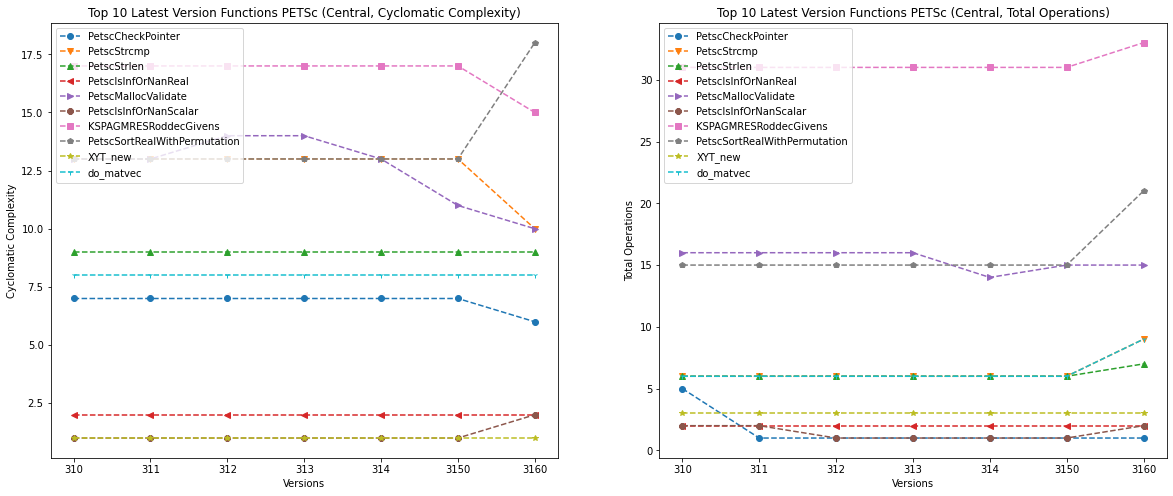

In [105]:
plots   = [] 
lacking = [] 
my_max = 0 
for v in versions: 
  to_plot   = [] 
  not_found = [] 
  for func in top_grpL.index: 
    try: 
      to_plot.append(PETSC[v]['QM'].CC[func]) 
    except KeyError: 
      to_plot.append(0) 
      not_found.append(func) 
  if max(to_plot) > my_max:
    my_max = max(to_plot)
  lacking.append(not_found) 
  plots.append(np.array(to_plot))  
np_plots = np.array(plots) 
i = 0 
fig, ax = plt.subplots(figsize=(20,8), nrows=1, ncols=2) 
# ax[0].set_ylim(my_max)
ax[0].set_title('Top 10 Latest Version Functions PETSc (Central, Cyclomatic Complexity)')
ax[0].set_xticklabels([e for j, e in enumerate([''] + versions)]) 
ax[0].set_xlabel('Versions')
ax[0].set_ylabel('Cyclomatic Complexity')

for arr in np_plots.T: 
  ax[0].plot(arr, markers[i]) 
  i += 1 
ax[0].legend(top_grpL.index, loc='upper left')
# plt.savefig("Top10FirstVersionCentral.pdf", bbox_inches='tight')

# with Betweenness 
plots   = [] 
lacking = [] 
for v in versions: 
  to_plot   = [] 
  not_found = [] 
  for func in top_grpL.index: 
    try: 
      to_plot.append(PETSC[v]['QM'].TotalOps[func]) 
    except KeyError: 
      to_plot.append(0) 
      not_found.append(func) 
  if max(to_plot) > my_max: 
    my_max = max(to_plot)
  lacking.append(not_found) 
  plots.append(np.array(to_plot))  
np_plots = np.array(plots) 
i = 0 
# fig, ax = plt.subplots(figsize=(12,16), nrows=1, ncols=2) 
# ax[0].set_ylim(my_max)
# ax[1].set_ylim(my_max)
ax[1].set_title('Top 10 Latest Version Functions PETSc (Central, Total Operations)')
ax[1].set_xticklabels([e for j, e in enumerate([''] + versions)]) 
ax[1].set_xlabel('Versions')
ax[1].set_ylabel('Total Operations')

for arr in np_plots.T: 
  ax[1].plot(arr, markers[i]) 
  i += 1 
ax[1].legend(top_grpL.index, loc='upper left')
plt.savefig("Top10LatestVersionCentralQMetrics.pdf", bbox_inches='tight')